# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
#df.info()
#пропуске есть в столбце Balance

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].unique()
#пропуски обозначены словом 'unknown'

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
import numpy as np

def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
fill_data = df.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'balance': fill_data['balance'].median(),
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()
round((df['balance'].mean()), 3) #Задание 2.3    +
round((fill_data['balance'].mean()), 3) #Задание 2.4
fill_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
fill_data['job'] = fill_data['job'].replace('unknown', 'management') 
fill_data['education'] = fill_data['education'].replace('unknown', 'secondary') 
av_balance= fill_data[(fill_data['job'] == 'management') & (fill_data['education'] == 'secondary')]['balance'].mean()
display(round((av_balance), 3))

np.float64(1598.883)

### Задание 6

In [9]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]   
    return outliers, cleaned, lower_bound, upper_bound
outliers, cleaned, lower_bound, upper_bound  = outliers_iqr(fill_data, 'balance') 
df_nb = fill_data[(fill_data['balance'] >= lower_bound) & (fill_data['balance'] <= upper_bound)]
print(lower_bound, upper_bound)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

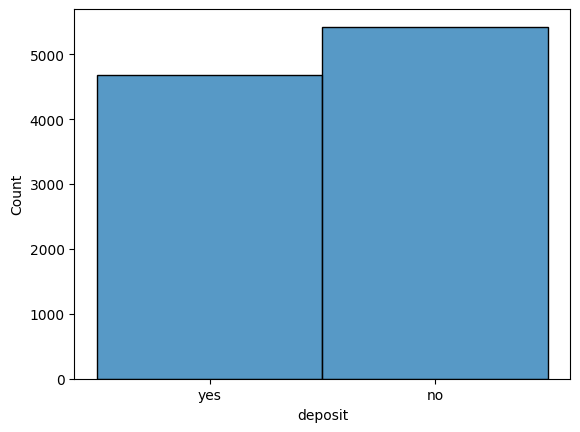

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
sns.histplot(df_nb['deposit'])
df_nb['deposit'].value_counts()
#Классы сбалансированы открывших дипозит клиентов чуть меньше чем неоткрывших

### Задания 2 и 3

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df_nb['age'].max() #Задание 2.2
df_nb.info()
df_nb.describe() #Задание 2.3

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

Т.к у нас целевая переменная столбец 'deposit' будет в каждом из графиков сравнивать остальные столбцы по признаку открыт депозит или нет 

<Axes: xlabel='count', ylabel='job'>

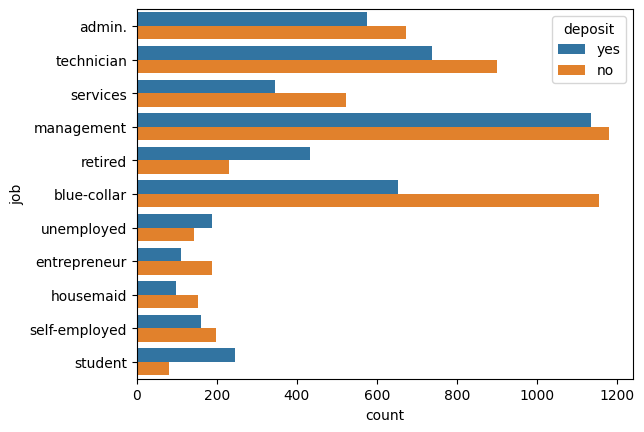

In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df_nb.mode()# этой функцией мы узнаем моду в каждой столбце 
#постройте визуализации, иллюстрирующие результаты
# Провизуализируем столбец 'job' 
sns.countplot(df_nb, y='job', hue='deposit')


#Интересно что не у всех профессий наблюдается (общая) тенденция как по всему дата сету что тех у кого открыт депозит их чуть меньше чем у тех кого он не открыт: как видно из графика открывших депозит больше у пенсионеров(retired), у безработных (uneemployment) и студентов 

#Интересно что не у всех профессий наблюдается (общая) тенденция как по всему дата сету что тех у кого открыт депозит их чуть меньше чем у тех кого он не открыт: как видно из графика открывших депозит больше у пенсионеров(retired), у безработных (uneemployment) и студентов 

Text(0.5, 1.0, 'откр/неоткр депозита в зависимости от семейного положения')

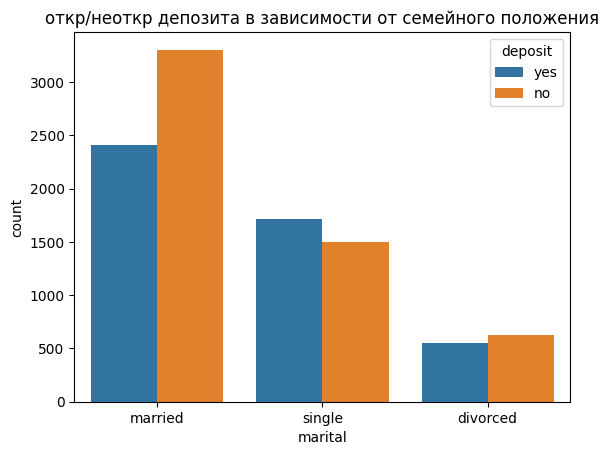

In [13]:
sns.countplot(df_nb, x='marital', hue='deposit')
plt.title('откр/неоткр депозита в зависимости от семейного положения')

#самый большой класс из 3ёх это женатые, как видно из графика у одиноких количество открывших депозит преобладает на неоткрывшими 

<Axes: xlabel='education', ylabel='count'>

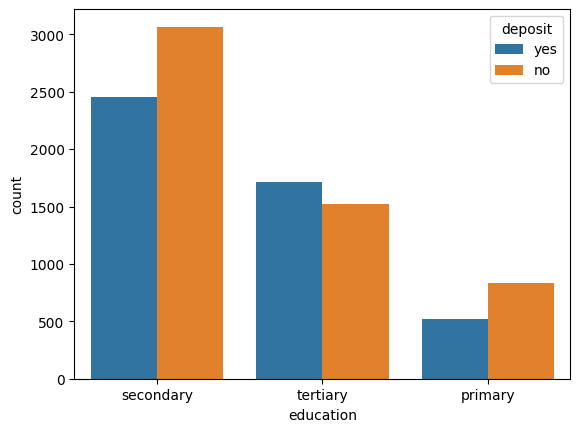

In [14]:
sns.countplot(df_nb, x='education', hue='deposit')

# если я правильно понял то названия +начальный(primary) потом вторичное и третичное не совсем ясно что это значит эти два последних но вторичных самое большое количество свыше 5500 клиентов а у тритечного образования преобладают открывшие депозит


Text(0.5, 1.0, 'Сравнение есть ли просроченный кредит при закр/откр депозите')

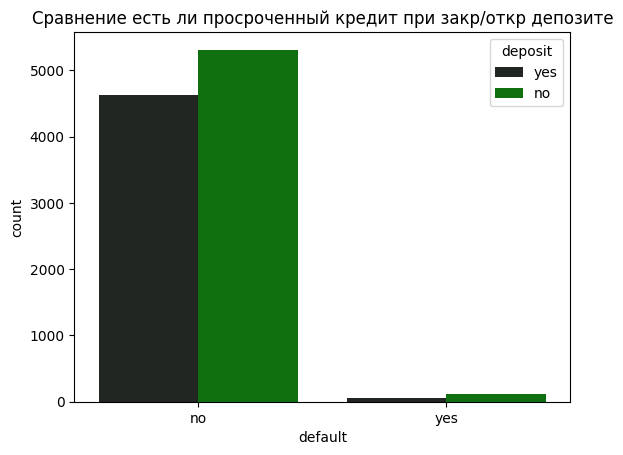

In [15]:
sns.countplot(df_nb, x='default', hue='deposit', color='g')
plt.title('Сравнение есть ли просроченный кредит при закр/откр депозите')

#Просроченные кредиты есть у маленького числа клиентов

12

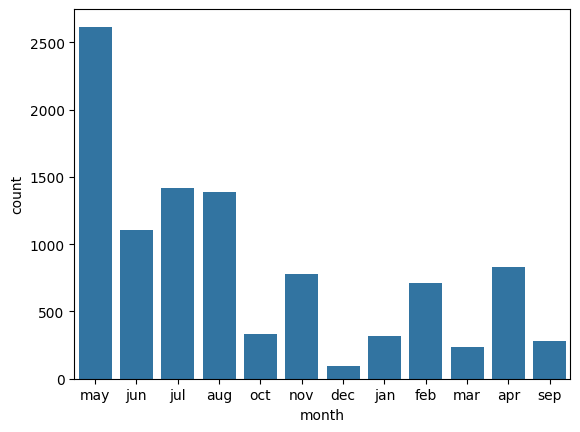

In [16]:
sns.countplot(df_nb, x='month')#график построен для наглядности 
df_nb['month'].nunique()
#Задание 3.4 12 видим в ответе функции 12 и на графике 12 месяцев 


In [17]:
#Задание 3.5 11 сфер занрятости 
df_nb['job'].nunique()

11

### Задание 6

Text(0.5, 0, 'Результат прошлой маркетинговой кампании')

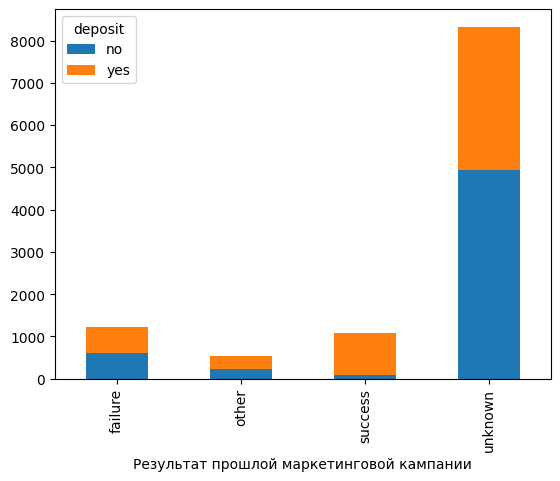

In [18]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
plt.xlabel('Результат прошлой маркетинговой кампании')

#Неизвестных как мы видим подавляющее большинство 

### Задание 7

<Axes: xlabel='month', ylabel='campaign'>

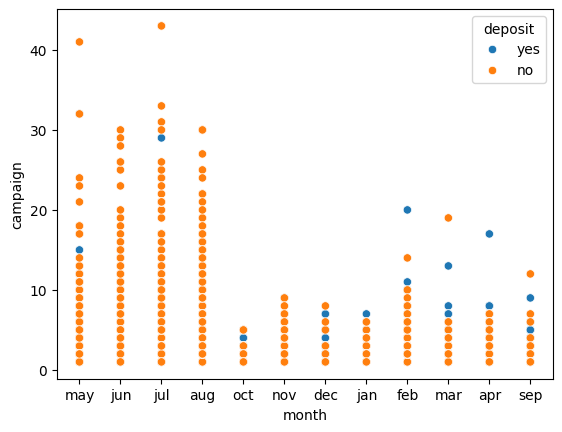

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
sns.scatterplot(df_nb, x='month', y="campaign", hue='deposit')
# сдесь у меня не верно я не понял как тут что

### Задание 8

Text(0.5, 1.0, 'откр/неоткр депозита по возрастным группам ')

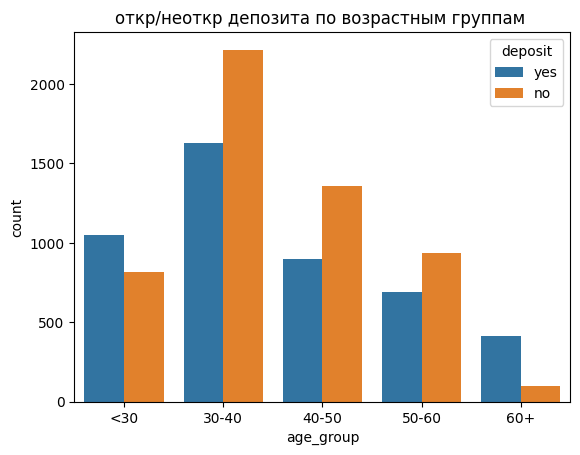

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_nb['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_nb)
plt.title('откр/неоткр депозита по возрастным группам ')

в группах меньше 30 и больше 60 больше клиентов согласились открыть депозит остальные не открывшие депозит преобладают

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

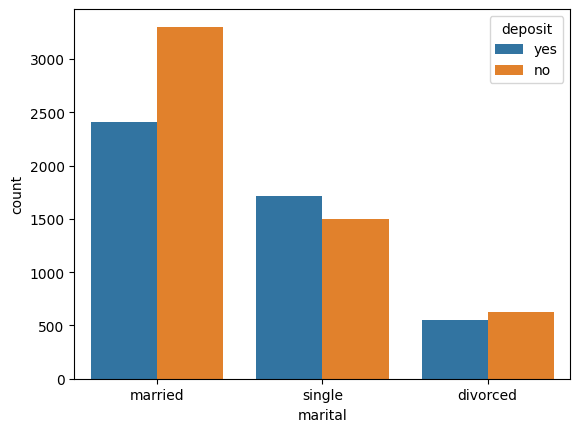

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(df_nb, x='marital', hue='deposit')

в браке по количеству преобладают а у клиентов одиночек согласившихся больше чем не согласившихся 

<Axes: xlabel='education', ylabel='count'>

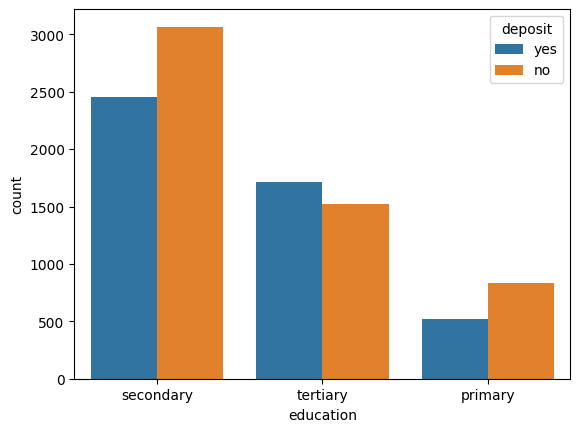

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(df_nb, x='education', hue='deposit')

вторичное образование по самая большая группа а третичное больше согласились чем нет 

Text(0.5, 1.0, 'кол-во откр/неоткр депозит взависимости от вида дейтельности')

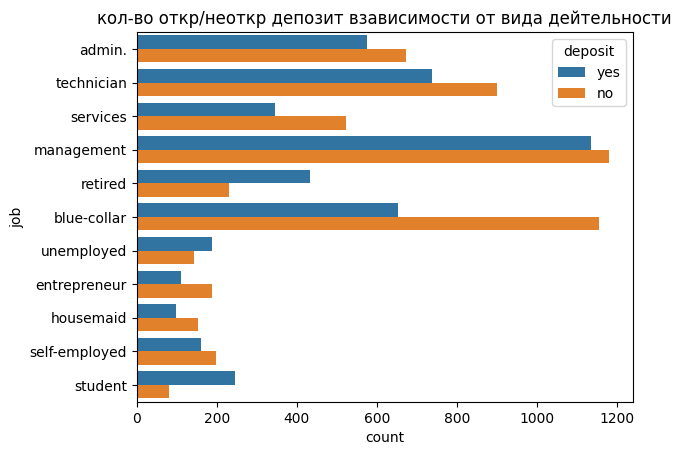

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(df_nb, y='job', hue='deposit')
plt.title('кол-во откр/неоткр депозит взависимости от вида дейтельности')

тут можно сделать вывод что студенты пенсионеры и безработные чаще говорили да чем нет в открытии депозита 

### Задание 11

col_0    divorcedprimary  divorcedsecondary  divorcedtertiary  marriedprimary  \
deposit                                                                         
no                    91                370               163             641   
yes                   96                283               174             339   

col_0    marriedsecondary  marriedtertiary  singleprimary  singlesecondary  \
deposit                                                                      
no                   1830              832            100              866   
yes                  1289              784             82              879   

col_0    singletertiary  
deposit                  
no                  531  
yes                 755  


<Axes: xlabel='col_0', ylabel='deposit'>

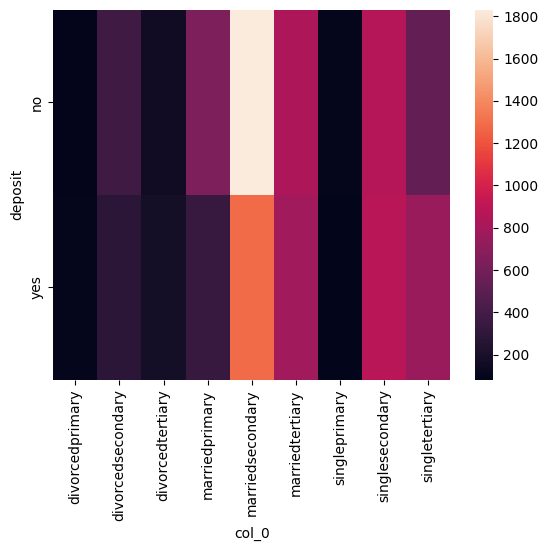

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
target_deposit = ['yes', 'no']
filtered_df = df_nb[df_nb['deposit'].isin(target_deposit)].copy()
filtered_df_2 = df_nb['marital'] + df_nb['education']
cross_table = pd.crosstab(filtered_df['deposit'], filtered_df_2)
print(cross_table)
sns.heatmap(cross_table)
#Самые многочисленные группы  клиенты со вторичное образование и в браке

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
lab_enc = LabelEncoder()

# Кодирование признака
df_nb['education'] = lab_enc.fit_transform(df_nb['education'])
df_nb['education'].sum()

np.int64(11995)

### Задания 2 и 3

In [26]:
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# преобразуйте бинарные переменные в представление из нулей и единиц
bin_encoder = LabelEncoder() # указываем столбец для кодирования
type_deposit = bin_encoder.fit_transform(df_nb['deposit'])
std_1 = round(type_deposit.std(), 3)
bin_encoder = LabelEncoder() # указываем столбец для кодирования
type_bin_default = bin_encoder.fit_transform(df_nb['default'])
std_2 = type_bin_default.mean()
bin_encoder = LabelEncoder() # указываем столбец для кодирования
type_bin_housing = bin_encoder.fit_transform(df_nb['housing'])
std_3 = type_bin_housing.mean()
bin_encoder = LabelEncoder() # указываем столбец для кодирования
type_bin_loan = bin_encoder.fit_transform(df_nb['loan'])
std_4 = type_bin_loan.mean()
bin_encoder = LabelEncoder() # указываем столбец для кодирования
type_bin_age = bin_encoder.fit_transform(df_nb['age_group'])
print(round(std_2 + std_3 + std_4, 3))
df_nb['coded_deposit'] = type_deposit
df_nb['coded_default'] = type_bin_default
df_nb['coded_housing'] = type_bin_housing
df_nb['coded_loan'] = type_bin_loan
df_nb['age_group_code'] = type_bin_age
df_nb['age_group_code'].unique()


0.635


array([2, 1, 0, 4, 3])

### Задание 4

In [27]:
# создайте дамми-переменные
# Добавляем закодированные столбцы в датасет
clothing_dummies = pd.get_dummies(df_nb, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
clothing_dummies.shape


(10105, 51)

### Задания 5 и 6

<Axes: >

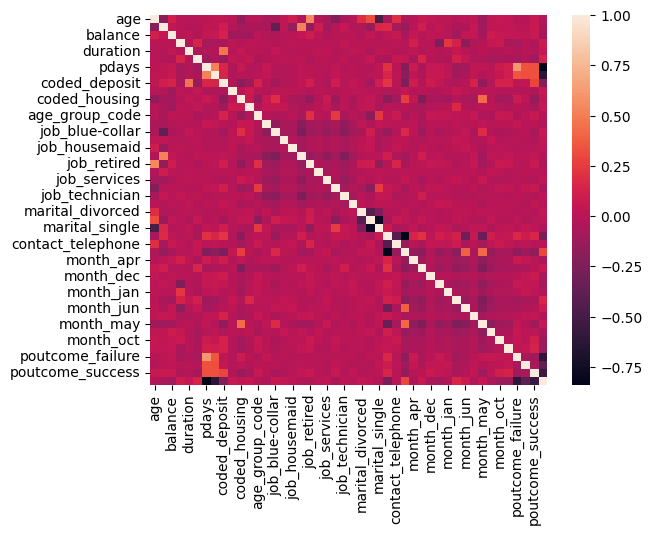

In [28]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(clothing_dummies.corr(numeric_only=True))
#наличия мультиколлинеарности нет

### Задания 7 и 8

In [29]:
Features = ['balance', 'duration', 'campaign', 'pdays', 'previous',
       'coded_housing', 'age_group_code', 'contact_cellular',
       'contact_unknown', 'month_mar', 'month_may', 'month_oct',
       'month_sep', 'poutcome_success', 'poutcome_unknown']
X = clothing_dummies[Features]
y = clothing_dummies['coded_deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 15)

In [30]:
# рассчитайте необходимые показатели
round(y_test.mean(), 2)


np.float64(0.46)

### Задание 9

In [31]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()



array(['balance', 'duration', 'campaign', 'pdays', 'previous',
       'coded_housing', 'age_group_code', 'contact_cellular',
       'contact_unknown', 'month_mar', 'month_may', 'month_oct',
       'month_sep', 'poutcome_success', 'poutcome_unknown'], dtype=object)

### Задание 10

In [32]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(round(X_test_scaled[:, 2].mean(), 2))  # для признака balance, обратите внимание именно на столбец 

0.04


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [34]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)

lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
print(round(metrics.accuracy_score(y_test, y_test_pred), 2))


0.81


### Задания 2,3,4

In [35]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
print(round(metrics.accuracy_score(y_test, y_test_pred), 2))

0.81


### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
#print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [37]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))
y_test_pred = model_cv.predict(X_test_scaled)
print('Recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.83
Recall на тестовом наборе: 0.81


### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('precision_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80
accuracy на тестовом наборе: 0.81
recall на тестовом наборе: 0.81
precision_score на тестовом наборе: 0.79


### Задание 4

In [39]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]#

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)# мета модель 
)
stack.fit(X_train_scaled, y_train)
print('precision_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

precision_score на тестовом наборе: 0.79


### Задание 5

In [40]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# 1) duration (продолжительность контакта в секундах) является самым важным думаю потомучто чем больше секунд разговаривает клиент тем он более заинтересован в услугах банка а не бросил сразу трубку 
# 2) poutcome_success, переменная успеха прошлой компании что говорит о том что клиент заинтересовался
# 3) contact_unknown тип контакта неизвестный непонятно как это тут оказалось видимо с этим типом контакта клиенты в большом % были лояльны открыть депозит


### Задания 6,7,8

In [41]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1);
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score = metrics.accuracy_score(y_train, model.predict(X_train_scaled))
  return score


In [42]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-08-15 19:24:27,253] A new study created in memory with name: RandomForestClassifier
[I 2025-08-15 19:24:28,145] Trial 0 finished with value: 0.8700147710487445 and parameters: {'n_estimators': 150, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8700147710487445.
[I 2025-08-15 19:24:29,059] Trial 1 finished with value: 0.8676514032496307 and parameters: {'n_estimators': 180, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8676514032496307.
[I 2025-08-15 19:24:29,818] Trial 2 finished with value: 0.8555391432791728 and parameters: {'n_estimators': 170, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8555391432791728.
[I 2025-08-15 19:24:30,951] Trial 3 finished with value: 0.895864106351551 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8555391432791728.
[I 2025-08-15 19:24:31,569] Trial 4 finished with value: 0.9258493353028066 and parameters: {'n_e

CPU times: total: 14.4 s
Wall time: 14.8 s


если добавить параметр direction="maximize" то можно ещё апнуть метрики

In [43]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))


Наилучшие значения гиперпараметров {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 10}
f1_score на обучающем наборе: 0.86


In [44]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Гдето не совпадают метрики на 0.2 - 0.3 как и было сказано в вебинаре 